In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from geneticalgorithm import geneticalgorithm as ga

In [2]:
class Node:
    def __init__(self, i, val, dist):
        self.id = i
        self.val = np.array(val)
        self.dist = dist
        
        self.child = []
        self.depth = 0
        self.degree = 0
        self.parent = None
        self.angle = None
        self.dist_from_parent = None
        
    def addChild(self, child):
        self.child.append(child)
        self.degree += 1
    def setParent(self, parent):
        self.parent = parent
        self.setAngleWithVertical()
        self.setDistFromParent()
        
    def setAngleWithVertical(self):
        temp = self.val - self.parent.val
        self.angle = np.rad2deg(np.arccos(np.dot(temp, np.array([0, 0, 1]))/np.linalg.norm(temp)))
    
    def setDistFromParent(self):
        self.dist_from_parent = np.linalg.norm(self.val-self.parent.val)

In [3]:
def initialize_graph(filename):
    f = open(filename, "r", newline="\n")
    t = f.readlines()
    #print(t[2].split("\n")[0])
    
    n = list(eval(t[0].split("\n")[0]))
    e = list(eval(t[1].split("\n")[0]))
    d = dict(eval(t[2].split("\n")[0]))
    nodes = dict()
    encoding = dict()

    
    for i, v in enumerate(n):
        nodes[i] = Node(i, v, d[v])
        encoding[v] = i
        
    for (par, chd) in e:
        p = encoding[par]
        c = encoding[chd]
        nodes[p].addChild(nodes[c])
        
        nodes[p].degree += 1
        nodes[c].degree += 1

        nodes[c].depth = nodes[p].depth + 1
        nodes[c].setParent(nodes[p])
        
    root = nodes[0]
    
    return root, nodes, encoding

In [4]:
root, nodes, encoding =initialize_graph('result3d.txt')

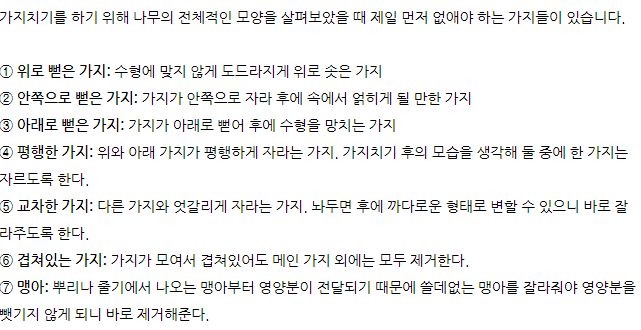

In [5]:
# Function to minimize
def fitness(X):
    visit = []
    queue = [root]
    penalty = 0
    
    '''
    if X[0] != 0:
        queue.append(root)

    else:
        return 1000000
    '''
    for i in nodes:
        current = nodes[i]
        if current.parent:
            # 부모노드와의 거리
            if current.dist_from_parent > 10:
                penalty += 1
            if X[current.parent.id] == 0:
                penalty+=100
        #depth
        if current.depth >= 7:
            penalty += 1/5*current.depth ##몇이 적당할까?? 상댓값으로 바꿀까??
        #vector
        '''if current.vector:
            if innerProduct(current.vector, [0,-1])<15: ##-y축 방향으로 +-15도
                penalty +=1'''
        # 수직선과의 각도
        if current.angle:
            if current.angle < 60 or current.angle > 90:
                penalty += 1

        # root로부터 거리
        if current.dist > 50:
            penalty += 1

        # degree
        if current.degree >= 4:
            penalty+=1

            
    return -len(visit) + penalty           
    #return 1/(penalty+1) 

In [6]:
model=ga(function=fitness, dimension=len(nodes), variable_type='bool')

model.run()

|||_______________________________________________ 6.1% GA is running...

KeyboardInterrupt: 

In [ ]:
chromosome = model.output_dict['variable']
chromosome

In [ ]:
sum(chromosome)

In [ ]:
visit = []
queue = [root]
penalty = 0

while queue:
    current = queue.pop(0)
    if current not in visit and chromosome[current.id] != 0:
        queue.extend(current.child)
        visit.append(current)
print(len(visit))

In [ ]:
%matplotlib qt

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import json
import ast
from mpl_toolkits.mplot3d import Axes3D

def prunedPlot():
    result = nx.DiGraph()
    
    q = [root]
    visited = [root]
    
    while q:
        curr = q.pop(0)
        q.extend(curr.child)
        if curr not in visited:
            visited.append(curr)
            result.add_node(tuple(curr.val))
            for child in curr.child:
                result.add_edge(tuple(curr.val), tuple(child.val))
            
    x, y, z = [], [], []
    for node in result.nodes:
        x.append(node[0])
        y.append(node[1])
        z.append(node[2])
    fig = plt.figure(figsize=(12, 12))
    ax = plt.axes(projection='3d')
    ax.scatter(x, y, z, s=1)

    for edge in result.edges:
        x = [edge[0][0], edge[1][0]]
        y = [edge[0][1], edge[1][1]]
        z = [edge[0][2], edge[1][2]]
        if chromosome[encoding[edge[0]]] == 0 or chromosome[encoding[edge[1]]] == 0:
            ax.plot(x, y, z, 'bo-')
        else:
            ax.plot(x, y, z, 'ro-')

    plt.show()

prunedPlot()

# 참고
* https://github.com/DEAP/deap